In [3]:
#Importação do arquivo 'depoimentos.data' para a variável data
import pandas as pd
df = pd.read_csv('depoimentos.data', sep=";")

#Visualizamos o conteúdo das 10 primeiras linhas
df.head(10)

,startup,avaliacao,processado,neutro,positivo,negativo,misto
0,99,Certamente o pior lugar que já trabalhei na vi...,False,NaN,NaN,NaN,NaN
1,99,Péssimo. Acho que a pior parte é a hipocrisia....,False,NaN,NaN,NaN,NaN
2,99,"Desorganizada, com problemas sérios de gestão,...",False,NaN,NaN,NaN,NaN
3,99,"A 99 já foi uma startup decente, refletindo os...",False,NaN,NaN,NaN,NaN
4,99,"Antes a 99 era incrível, desenvolvíamos tecnol...",False,NaN,NaN,NaN,NaN
5,18moons,É o cliente deitando e rolando o tempo todo em...,False,NaN,NaN,NaN,NaN
6,1Doc,"Um dos founders acredita que ""mulher bonita ve...",False,NaN,NaN,NaN,NaN
7,4all,"No início era maravilhosa, um time ótimo, ener...",False,NaN,NaN,NaN,NaN
8,4all,"A estrutura e ambiente (localização, salas, ma...",False,NaN,NaN,NaN,NaN
9,4YOU2 idiomas,"Benefícios praticamente inexistentes, CEO dá b...",False,NaN,NaN,NaN,NaN


In [4]:
#Vamos verificar quantas análises cada startup possui
df[['startup','avaliacao']].groupby(['startup'])['avaliacao'] \
                           .count() \
                           .reset_index(name='count') \
                           .sort_values(['count'], ascending=False) \
                           .head(10)

,startup,count
22,Banco Neon,24
150,Nubank,17
188,Samba Tech,17
35,Cabify,11
179,Resultados Digitais,11
182,Rock Content,10
101,Hotmart,8
211,Thoughtworks,8
161,Pagar.me,8
140,Movile,7


In [4]:
#Analisa o dataset como um todo
df.describe()

,neutro,positivo,negativo,misto
count,525.000000,525.000000,525.000000,525.000000
mean,0.222419,0.380095,0.294571,0.101981
std,0.332847,0.438855,0.395267,0.226086
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.020000,0.050000,0.030000,0.000000
75%,0.350000,0.960000,0.680000,0.050000
max,1.000000,1.000000,1.000000,1.000000


In [5]:
#Inicializa o objeto da Amazon
import boto3
import json

#Documentação da API de Sentiments: https://docs.aws.amazon.com/comprehend/latest/dg/API_DetectSentiment.html
client = boto3.client('comprehend', 
                      aws_access_key_id='SUA_ACCESS_KEY_ID', 
                      aws_secret_access_key='SUA_SECRET_ACCESS_KEY', 
                      region_name='us-east-1')

In [19]:
#Faz um loop nos registros que ainda não foram processados para chamar a API da AWS
for index, row in df.loc[df['processado'] == False].iterrows():
    
    #consome a API de detecção de sentimento
    response = client.detect_sentiment(Text=row['avaliacao'][:5000], LanguageCode='pt')

    #Altera o registro
    df.loc[index, "processado"] = True
    df.loc[index, "positivo"]   = round(response["SentimentScore"]["Positive"], 2)
    df.loc[index, "negativo"]   = round(response["SentimentScore"]["Negative"], 2)
    df.loc[index, "neutro"]     = round(response["SentimentScore"]["Neutral"], 2)
    df.loc[index, "misto"]      = round(response["SentimentScore"]["Mixed"], 2)


In [20]:
#Salva o dataset de volta no arquivo texto
df.to_csv('depoimentos.data', sep=";", index = False)

In [21]:
#Criação da coluna sentimento_predominante
import operator
def fn_sentimento(p_positivo, p_negativo, p_neutro, p_misto):
    scores = {'Positivo':p_positivo, 'Negativo':p_negativo, 'Neutro': p_neutro, 'Misto': p_misto}
    return max(scores.items(), key=operator.itemgetter(1))[0]

df['sentimento_predominante'] = df.apply(lambda row: fn_sentimento(row['positivo'], row['negativo'], row['neutro'], row['misto']), axis=1)


In [22]:
df.head(10)

,startup,avaliacao,processado,neutro,positivo,negativo,misto,sentimento_predominante
0,99,Certamente o pior lugar que já trabalhei na vi...,True,0.00,0.00,0.99,0.00,Negativo
1,99,Péssimo. Acho que a pior parte é a hipocrisia....,True,0.00,0.00,1.00,0.00,Negativo
2,99,"Desorganizada, com problemas sérios de gestão,...",True,0.01,0.00,0.99,0.00,Negativo
3,99,"A 99 já foi uma startup decente, refletindo os...",True,0.98,0.00,0.00,0.01,Neutro
4,99,"Antes a 99 era incrível, desenvolvíamos tecnol...",True,0.01,0.96,0.02,0.01,Positivo
5,18moons,É o cliente deitando e rolando o tempo todo em...,True,0.07,0.00,0.93,0.00,Negativo
6,1Doc,"Um dos founders acredita que ""mulher bonita ve...",True,0.91,0.07,0.02,0.00,Neutro
7,4all,"No início era maravilhosa, um time ótimo, ener...",True,0.18,0.05,0.16,0.62,Misto
8,4all,"A estrutura e ambiente (localização, salas, ma...",True,0.14,0.02,0.55,0.28,Negativo
9,4YOU2 idiomas,"Benefícios praticamente inexistentes, CEO dá b...",True,0.11,0.48,0.37,0.03,Positivo


In [23]:
#Cria um dataset contendo o sentimento e a quantidade de ocorrências
df_predom = df[['startup','sentimento_predominante']].groupby(['sentimento_predominante'])['sentimento_predominante'] \
                           .count() \
                           .reset_index(name='count') \
                           .sort_values(['sentimento_predominante'])
df_predom

,sentimento_predominante,count
0,Misto,47
1,Negativo,162
2,Neutro,112
3,Positivo,204


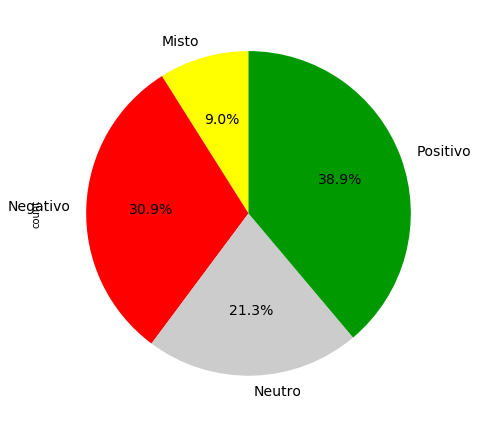

In [25]:
#Plota o gráfico de pizza
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
ax1 = plt.subplot(121, aspect='equal')
plot = df_predom.plot(kind='pie', 
               y='count', 
               labels=df_predom['sentimento_predominante'],
               ax=ax1,
               colors = ['yellow', '#ff0000', '#cccccc', '#009900'],
               autopct='%1.1f%%',
               startangle=90,
               shadow=False,
               legend=False,
               fontsize=14)

In [12]:
#Criação do dataset contendo uma linha por startup e uma coluna para cada sentimento predominante

#Cria tabela com agrupamento por startup e por sentimento predominante
df_startup = df[['startup','sentimento_predominante']].groupby(['startup','sentimento_predominante'])['startup'] \
                           .count() \
                           .reset_index(name='count') \
                           .sort_values(['startup'], ascending = True)
df_startup.head(10)

,startup,sentimento_predominante,count
0,18moons,Negativo,1
1,1Doc,Neutro,1
2,4YOU2 idiomas,Neutro,1
3,4YOU2 idiomas,Positivo,1
4,4all,Misto,1
5,4all,Negativo,1
6,4yousee,Positivo,3
8,99,Neutro,1
9,99,Positivo,2
7,99,Negativo,3


In [13]:
#pivota a tabela com a contagem de cada sentimento para cada startup
import numpy as np
df_pivoted = pd.pivot_table(df_startup, values='count', index=['startup'], columns=['sentimento_predominante'], aggfunc=np.sum)
df_pivoted = df_pivoted.where((pd.notnull(df_pivoted)), 0) #Converte os NaN como zeros
df_pivoted = df_pivoted.rename_axis(None) #remove o índice double-headed
df_pivoted.reset_index(level=0, inplace=True) #cria uma nova coluna com o índice (nome da startup)
df_pivoted.columns = ['startup', 'Misto', 'Negativo', 'Neutro', 'Positivo'] #renomeia as colunas
df_pivoted.head(10)

,startup,Misto,Negativo,Neutro,Positivo
0,18moons,0.0,1.0,0.0,0.0
1,1Doc,0.0,0.0,1.0,0.0
2,4YOU2 idiomas,0.0,0.0,1.0,1.0
3,4all,1.0,1.0,0.0,0.0
4,4yousee,0.0,0.0,0.0,3.0
5,99,0.0,3.0,1.0,2.0
6,99jobs,0.0,1.0,0.0,0.0
7,Accera,0.0,0.0,1.0,0.0
8,Agendor,0.0,1.0,2.0,1.0
9,Agrosmart,0.0,0.0,1.0,0.0


In [14]:
#Criamos uma coluna com a quantidade de avaliações e outra com o saldo (Positivo (-) Negativo)
#Não utilizamos a quantidade de misto ou neutro
df_pivoted['QtdeAval'] = df_pivoted['Positivo'] + df_pivoted['Negativo']
df_pivoted['Saldo']    = df_pivoted['Positivo'] - df_pivoted['Negativo']
df_pivoted.head(10)

,startup,Misto,Negativo,Neutro,Positivo,QtdeAval,Saldo
0,18moons,0.0,1.0,0.0,0.0,1.0,-1.0
1,1Doc,0.0,0.0,1.0,0.0,0.0,0.0
2,4YOU2 idiomas,0.0,0.0,1.0,1.0,1.0,1.0
3,4all,1.0,1.0,0.0,0.0,1.0,-1.0
4,4yousee,0.0,0.0,0.0,3.0,3.0,3.0
5,99,0.0,3.0,1.0,2.0,5.0,-1.0
6,99jobs,0.0,1.0,0.0,0.0,1.0,-1.0
7,Accera,0.0,0.0,1.0,0.0,0.0,0.0
8,Agendor,0.0,1.0,2.0,1.0,2.0,0.0
9,Agrosmart,0.0,0.0,1.0,0.0,0.0,0.0


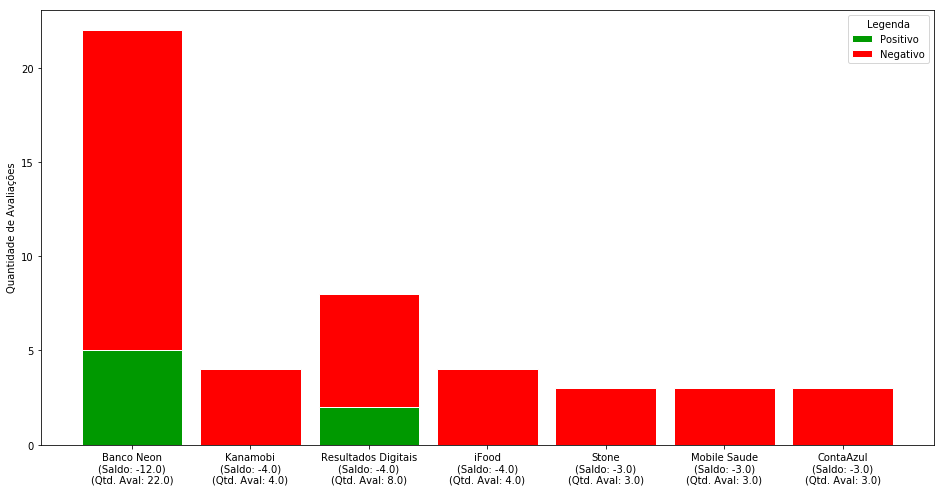

In [15]:
#As 7 piores startups
df_setepiores = df_pivoted.sort_values(by=['Saldo']).head(7)

r = [0,1,2,3,4,5,6]
totals          = [i+j for i,j in zip(df_setepiores['Positivo'], df_setepiores['Negativo'])]
barrasVerdes    = [i for i,j in zip(df_setepiores['Positivo'], totals)]
barrasVermelhas = [i for i,j in zip(df_setepiores['Negativo'], totals)]
#Se quiséssemos ver em percentual:
#barrasVerdes    = [i / j * 100 for i,j in zip(df_setepiores['Positivo'], totals)]
#barrasVermelhas = [i / j * 100 for i,j in zip(df_setepiores['Negativo'], totals)]
barWidth        = 0.85
names           = df_setepiores['startup'].map(str) + '\n(Saldo: ' + df_setepiores['Saldo'].map(str) + ')\n(Qtd. Aval: ' + df_setepiores['QtdeAval'].map(str) + ')'

plt.figure(figsize=(16,8))
plt.bar(r, barrasVerdes,    color='#009900', edgecolor='white', width=barWidth, label="Positivo")
plt.bar(r, barrasVermelhas, bottom=barrasVerdes, color='#ff0000', edgecolor='white', width=barWidth, label="Negativo")

plt.xticks(r, names)
plt.legend(loc='upper right', title='Legenda', bbox_to_anchor=(1,1), ncol=1)
plt.ylabel('Quantidade de Avaliações')
plt.show()

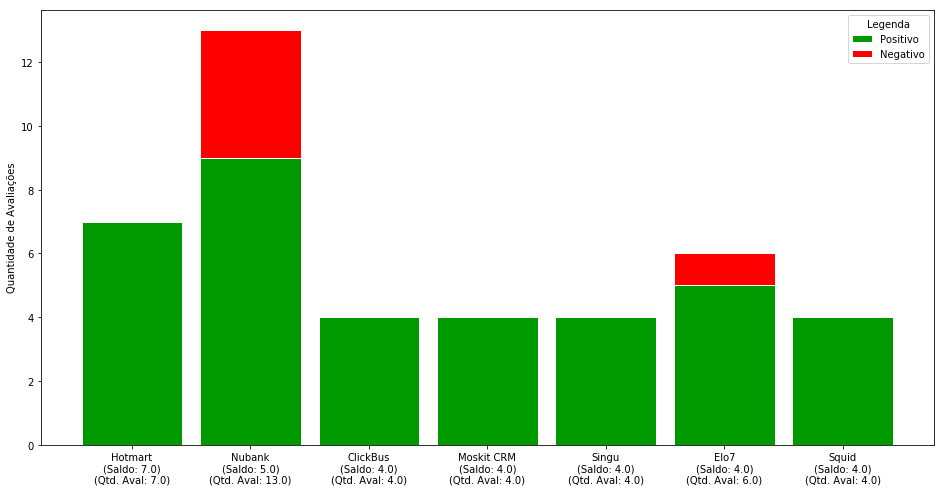

In [16]:
#As 7 melhores startups
df_setemelhores = df_pivoted.sort_values(by=['Saldo'], ascending=False).head(7)

r = [0,1,2,3,4,5,6]
totals          = [i+j for i,j in zip(df_setemelhores['Positivo'], df_setemelhores['Negativo'])]
barrasVerdes    = [i for i,j in zip(df_setemelhores['Positivo'], totals)]
barrasVermelhas = [i for i,j in zip(df_setemelhores['Negativo'], totals)]
barWidth        = 0.85
names           = df_setemelhores['startup'].map(str) + '\n(Saldo: ' + df_setemelhores['Saldo'].map(str) + ')\n(Qtd. Aval: ' + df_setemelhores['QtdeAval'].map(str) + ')'

plt.figure(figsize=(16,8))
plt.bar(r, barrasVerdes,    color='#009900', edgecolor='white', width=barWidth, label="Positivo")
plt.bar(r, barrasVermelhas, bottom=barrasVerdes, color='#ff0000', edgecolor='white', width=barWidth, label="Negativo")

plt.xticks(r, names)
plt.legend(loc='upper right', title='Legenda', bbox_to_anchor=(1,1), ncol=1)
plt.ylabel('Quantidade de Avaliações')
plt.show()